In [1]:
import sys

sys.path.append('../src/')

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from mrpython_pcl.LidarPipeline.ConeClassifier import ConeClassifier

import utils

## Lidar Settings

In [2]:
import yaml

with open('lidar_datasheet.yml', 'r') as f:
    data = yaml.safe_load(f)
    
LIDAR_VERTICAL_INCLINATION = 0
LIDAR_ORIGIN = (0,0,0.4) # METERS
LIDAR_VERTICAL_ANGLES = (np.array(data['LIDAR_VERTICAL_ANGLES'] ) + LIDAR_VERTICAL_INCLINATION).tolist()
LIDAR_POSITION_ACCURACY = data['LIDAR_POSITION_ACCURACY']
LIDAR_HORIZONTAL_FOV = data['LIDAR_HORIZONTAL_FOV']
LIDAR_RATE = data['LIDAR_RATE']
LIDAR_RATE_ACCURACY = data['LIDAR_RATE_ACCURACY']
# Calculate horizontal angle offset according to RPM
calculateHorizontalAzmuth = lambda rpm: rpm/60 * 360 * 55.269e-6 # degrees

## Cone Settings

In [3]:
N_SAMPLES = 10 # number of cone samples per distance to generate

# CONE CONSTANTS
CONE_HEIGHT = 0.33 # METERS
CONE_RADIUS = 0.1 # METERS

## Simulate LiDAR Intersections

In [4]:
def simulateLidar(d):
    # sample N_SAMPLES cones
    classifier = ConeClassifier(CONE_RADIUS, CONE_HEIGHT, 1,1,1)
    
    cost_tracker = {'linLoss':[], 'l2Loss':[]}
    
    for i in range(N_SAMPLES):
        cones = []
        angle = np.random.uniform(low=0, high=LIDAR_HORIZONTAL_FOV)
        cone = utils.getConeEquation(angle, d, CONE_HEIGHT, CONE_RADIUS)
        cones.append(cone)
        
        # scan using the lidar
        rotationAngle = np.rad2deg(np.arctan(CONE_RADIUS/d))
        intersections = []
        alpha = angle-rotationAngle
        
        for alpha in LIDAR_VERTICAL_ANGLES: # vertical angle
            theta = angle-rotationAngle
            while theta < angle+rotationAngle: # horizontal angle
                # get lidar ray
                ray = utils.getLineEquation(LIDAR_ORIGIN, alpha, theta)
                # get intersection point
                intersection = utils.computeIntersection(cone, ray)
                
                if intersection is not None:
                    if intersection[2]>=0 and intersection[2]<=CONE_HEIGHT:
                        #utils.visualizeLineAndCone(ray[:2],ray[3:5],cone[:2],CONE_RADIUS)
                        #print(intersection)
                        intersection = [np.random.normal(intersection[0], LIDAR_POSITION_ACCURACY), np.random.normal(intersection[1], LIDAR_POSITION_ACCURACY), intersection[2]]
                        intersections.append(intersection)

                rpm=np.random.uniform(low=LIDAR_RATE-LIDAR_RATE_ACCURACY, high=LIDAR_RATE+LIDAR_RATE_ACCURACY)
                theta+=calculateHorizontalAzmuth(rpm)
                
        # use the points to fit the X_c and y_c
        intersections = np.array(intersections)
        
        (_, linLoss, l2Loss), _ = classifier.isCone(intersections, returnLosses=True)
        cost_tracker['linLoss'].append(linLoss)
        
        # compute the sum of cost2
        cost_tracker['l2Loss'].append(l2Loss)
        
                    
    # compute the mean and std of sigma_cost1 and sigma_cost2
    thres1_mean = np.mean(cost_tracker['linLoss'])
    thres1_std = np.std(cost_tracker['linLoss'])
    thres2_mean = np.mean(cost_tracker['l2Loss'])
    thres2_std = np.std(cost_tracker['l2Loss'])
    
    return thres1_mean, thres1_std, thres2_mean, thres2_std, cost_tracker

In [5]:
thres1_mean, thres1_std, thres2_mean, thres2_std,_ = simulateLidar(1)
thres1_mean, thres1_std, thres2_mean, thres2_std

(4.149057574872338e-06,
 1.637034266724746e-06,
 0.018345556638925252,
 0.008715720893321278)

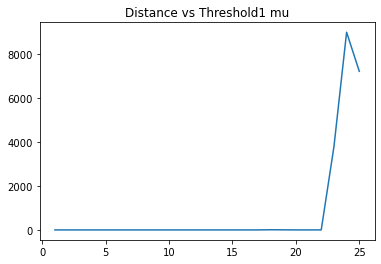

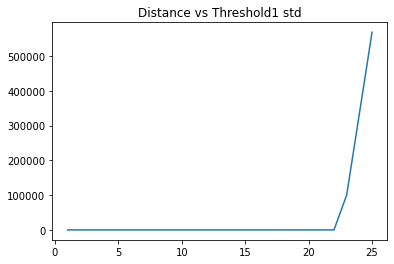

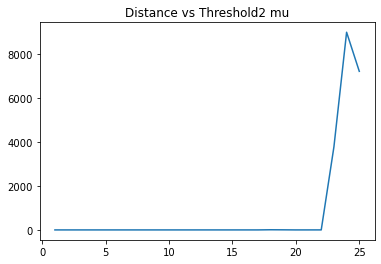

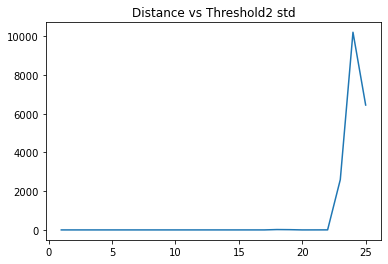

In [6]:
# simulate on many distances
t1MUList = []
t1STDList = []
t2MUList = []
t2STDList = []

for i in range(1,25+1):
    t1MU, t1STD, t1MU, t2STD,_ = simulateLidar(i)
    t1MUList.append(t1MU)
    t1STDList.append(t1STD)
    t2MUList.append(t1MU)
    t2STDList.append(t2STD)

distance_list = np.arange(1,25+1)
plt.plot(distance_list, t1MUList)
plt.title('Distance vs Threshold1 mu')
plt.show()
plt.plot(distance_list, t1STDList)
plt.title('Distance vs Threshold1 std')
plt.show()
plt.plot(distance_list, t2MUList)
plt.title('Distance vs Threshold2 mu')
plt.show()
plt.plot(distance_list, t2STDList)
plt.title('Distance vs Threshold2 std')
plt.show()